# KAN-ODE

## KODE网络训练

### 安装依赖

In [30]:
import sys
sys.path.append('/home/sdu123/WORK/KODE')

In [31]:
import time
start_time = time.time()

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import pandas as pd
from base_kan.ekan import EKAN 

### 定义网络
包含常规ODE和Neural ODE的SIR系统

In [33]:
# 定义普通的MLP
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 定义包含常规ODE和Neural ODE的SIR系统
class CustomSIRSystem(nn.Module):
    def __init__(self, neural_part, gamma, beta):
        super(CustomSIRSystem, self).__init__()
        self.neural_part = neural_part
        self.gamma = gamma
        self.beta = beta

    def forward(self, t, y):
        S, I, R = y
        neural_output = self.neural_part(torch.tensor([S, I], dtype=torch.float32).unsqueeze(0)).squeeze()
        dR_dt = self.gamma * I
        dI_dt = abs(neural_output) - self.gamma * I
        dS_dt = -abs(neural_output)
        return torch.stack([dS_dt, dI_dt, dR_dt])

### 初始化模型参数

In [34]:
# 初始化模型
gamma = 0.01
beta = 2 * gamma
neural_ode_func = SimpleMLP()
tmodel = CustomSIRSystem(neural_ode_func, gamma, beta)

### 初始化参数

In [35]:
intial = 0.  ##时间区间的初始值
last= 100.    ##时间区间的终值
step = 100    ##时间步长
y0 = torch.tensor([0.99, 0.01, 0.0], requires_grad=True)  # 初始条件: S, I, R
t = torch.linspace(intial, last, step)  # 时间区间

### 生成真实数据

In [36]:
def get_data():
    gamma = 0.01
    beta = 2 * gamma
    a = 0.2
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    def sir(t, y):
        S, I, R = y
        dS_dt = -beta * S * I * (10*torch.exp(-a*t)+5)
        dI_dt = beta * S * I * (10*torch.exp(-a*t)+5)- gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, true_y = get_data()

### 定义损失函数
#### 使用仅与I相关的损失函数

In [37]:
def compute_loss(pred_y, true_y):
    return torch.mean((pred_y[:, 2] - true_y[:, 2]) ** 2)

### 定义准确率计算函数
#### 使用仅与I相关的准确率函数

In [38]:
def compute_accuracy(pred_y, true_y, threshold=0.01):
    diff = torch.abs(pred_y[:, 2] - true_y[:, 2])
    correct = (diff < threshold).float().mean()
    return correct.item()

### 定义训练模型
执行模型的训练

In [39]:
def train():
    optimizer = optim.Adam(tmodel.parameters(), lr=1e-4)

    for itr in range(3000):
        optimizer.zero_grad()
        pred_y = odeint(tmodel, y0, t, rtol=1e-5, atol=1e-8)
        loss = compute_loss(pred_y, true_y)
        loss.backward()
        optimizer.step()

        if itr % 100 == 0:
            accuracy = compute_accuracy(pred_y, true_y)
            print(f'Iter {itr}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

    return t, true_y, pred_y

### 进行训练

In [40]:
t, true_y, pred_y = train()

Iter 0, Loss: 0.3601241707801819, Accuracy: 4.00%
Iter 100, Loss: 0.0009107635705731809, Accuracy: 21.00%
Iter 200, Loss: 0.0007580945384688675, Accuracy: 22.00%
Iter 300, Loss: 0.0007239583064801991, Accuracy: 22.00%
Iter 400, Loss: 0.0007065332029014826, Accuracy: 22.00%
Iter 500, Loss: 0.0006944687920622528, Accuracy: 23.00%
Iter 600, Loss: 0.0006825333111919463, Accuracy: 24.00%
Iter 700, Loss: 0.0006683568935841322, Accuracy: 24.00%
Iter 800, Loss: 0.000655665120575577, Accuracy: 23.00%
Iter 900, Loss: 0.0006381055573001504, Accuracy: 24.00%
Iter 1000, Loss: 0.0006211312720552087, Accuracy: 24.00%
Iter 1100, Loss: 0.0005974165978841484, Accuracy: 25.00%
Iter 1200, Loss: 0.0005674095591530204, Accuracy: 25.00%
Iter 1300, Loss: 0.0005284410435706377, Accuracy: 27.00%
Iter 1400, Loss: 0.0004965316038578749, Accuracy: 28.00%
Iter 1500, Loss: 0.00045771567965857685, Accuracy: 30.00%
Iter 1600, Loss: 0.0004234042717143893, Accuracy: 30.00%
Iter 1700, Loss: 0.0003614600282162428, Accurac

#### 定义差分机计算公式

In [41]:
def forword_CF(x):
    # 将输入转换为tensor
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
    # 检查输入长度是否至少为2
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
    # 初始化输出数列，复制第一个元素
    result = x.clone().detach()
    
    # 计算后一项减前一项
    result[1:] = x[1:] - x[:-1]
    
    return result

In [42]:
true_y[:,2] = forword_CF(true_y[:,2])
pred_y[:,2] = forword_CF(pred_y[:,2])

/tmp/ipykernel_3079502/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


### 将最终数据保存至Excel

In [43]:
data = {
    'Time': t.numpy(),
    'True_S': true_y.numpy()[:, 0],
    'Predicted_S': pred_y.detach().numpy()[:, 0],
    'True_I': true_y.numpy()[:, 1],
    'Predicted_I': pred_y.detach().numpy()[:, 1],
    'True_R': true_y.numpy()[:, 2],
    'Predicted_R': pred_y.detach().numpy()[:, 2],

}
df = pd.DataFrame(data)


### 保存成Excel文件

In [44]:
df.to_excel('result/H-tmlp.xlsx', index=False)

### 绘制结果并将图片结果保存

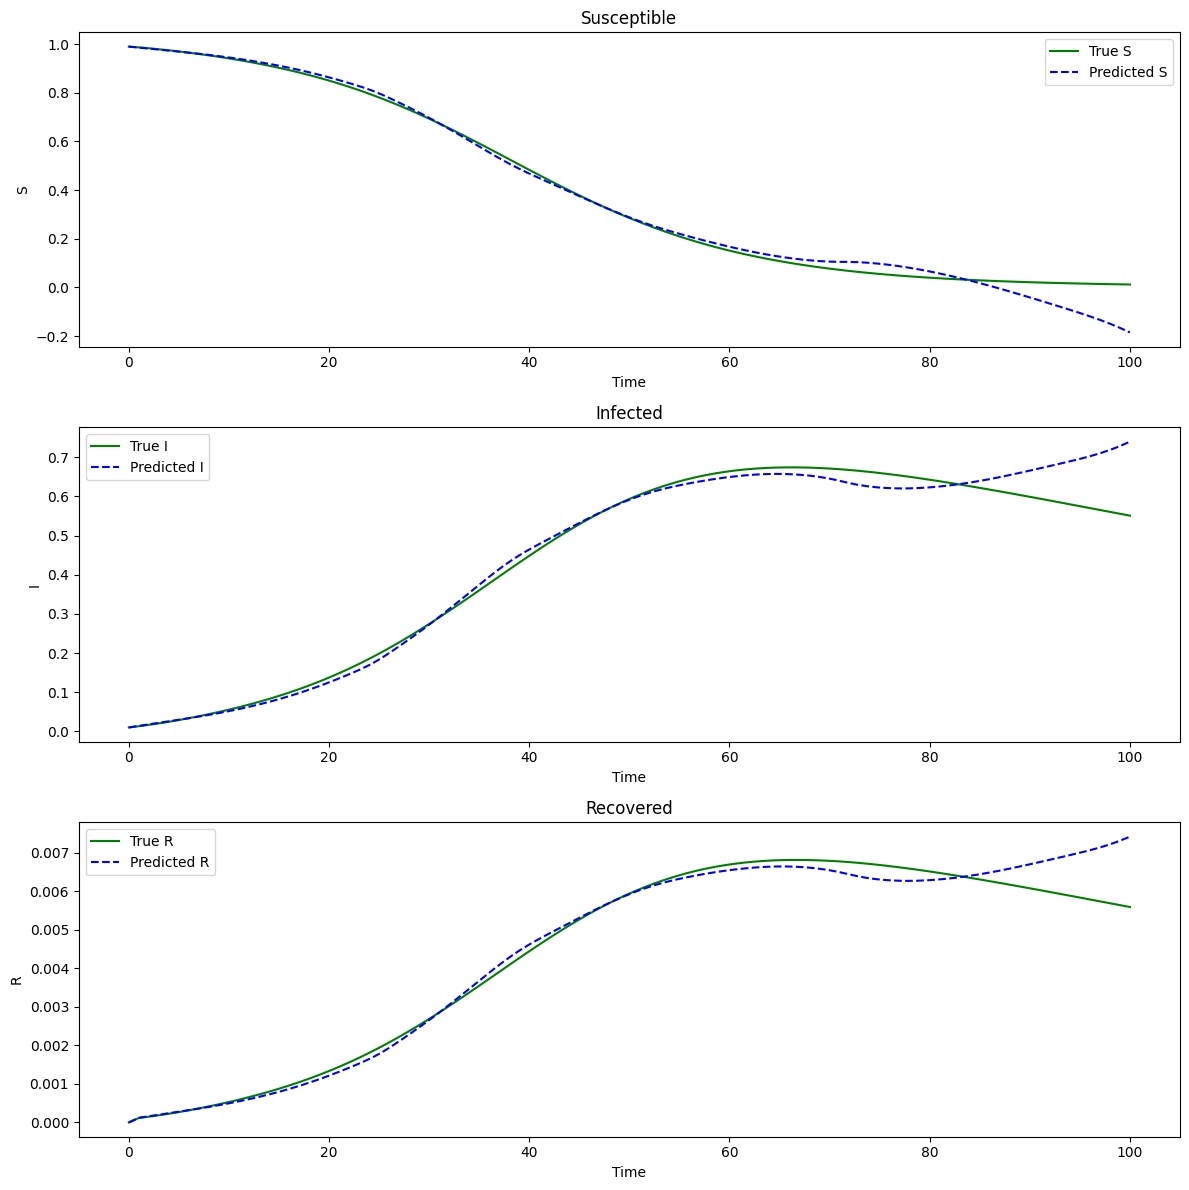

In [45]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t.numpy(), true_y.numpy()[:, 0], 'g-', label='True S')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 0], 'b--', label='Predicted S')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(t.numpy(), true_y.numpy()[:, 1], 'g-', label='True I')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 1], 'b--', label='Predicted I')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(t.numpy(), true_y.numpy()[:, 2], 'g-', label='True R')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 2], 'b--', label='Predicted R')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')

plt.tight_layout()
plt.savefig('picture/H-tmlp.png')
plt.show()


## 推理阶段

### 设置预测的时间

In [46]:
##将时间步长进行扩展
extend = 40
timeintial = intial
timeend = last + extend
timestep = step + extend
in_t = torch.linspace(timeintial, timeend, timestep)##预测接下来extend天的情况

### 真实机理数据推理

In [48]:
def get_data():
    gamma = 0.01
    beta = 2 * gamma
    a = 0.2
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    def sir(t, y):
        S, I, R = y
        dS_dt = -beta * S * I * (10*torch.exp(-a*t)+5)
        dI_dt = beta * S * I * (10*torch.exp(-a*t)+5) - gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, in_t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, in_true_y = get_data()

### 机理部分的推理

In [49]:
def get_data():
    gamma = 0.01
    beta = 2 * gamma
    a = 0.2
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    def sir(t, y):
        S, I, R = y
        dS_dt = -beta * S * I * (10*torch.exp(-a*t)+5)
        dI_dt = beta * S * I * (10*torch.exp(-a*t)+5) - gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        in_true_y = odeint(sir, true_y0, in_t, rtol=1e-5, atol=1e-8)
    return in_t, in_true_y

in_t, in_NH_true_y = get_data()

### 神经网络部分的推理

In [50]:
with torch.no_grad():
    in_pred_y = odeint(tmodel, y0, in_t, rtol=1e-5, atol=1e-8)

#### 定义差分机计算公式

In [51]:
def forword_CF(x):
    # 将输入转换为tensor
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
    # 检查输入长度是否至少为2
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
    # 初始化输出数列，复制第一个元素
    result = x.clone().detach()
    
    # 计算后一项减前一项
    result[1:] = x[1:] - x[:-1]
    
    return result

In [52]:
in_true_y[:,2] = forword_CF(in_true_y[:,2])
in_pred_y[:,2] = forword_CF(in_pred_y[:,2])
in_NH_true_y[:,2] = forword_CF(in_NH_true_y[:,2])

/tmp/ipykernel_3079502/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


### 将推理阶段的结果进行保存

In [53]:
in_data = {
    'Time': in_t.numpy(),
    'True_S': in_true_y.numpy()[:, 0],
    'Equation_S': in_NH_true_y.numpy()[:, 0],
    'Predicted_S': in_pred_y.detach().numpy()[:, 0],
    'True_I': in_true_y.numpy()[:, 1],
    'Equation_I': in_NH_true_y.numpy()[:, 1],
    'Predicted_I': in_pred_y.detach().numpy()[:, 1],
    'True_R': in_true_y.numpy()[:, 2],
    'Equation R': in_NH_true_y.numpy()[:, 2],
    'Predicted_R': in_pred_y.detach().numpy()[:, 2],

}
in_df = pd.DataFrame(in_data)
in_df.to_excel('result/in_H-tmlp.xlsx', index=False)

### 将推理阶段可视化

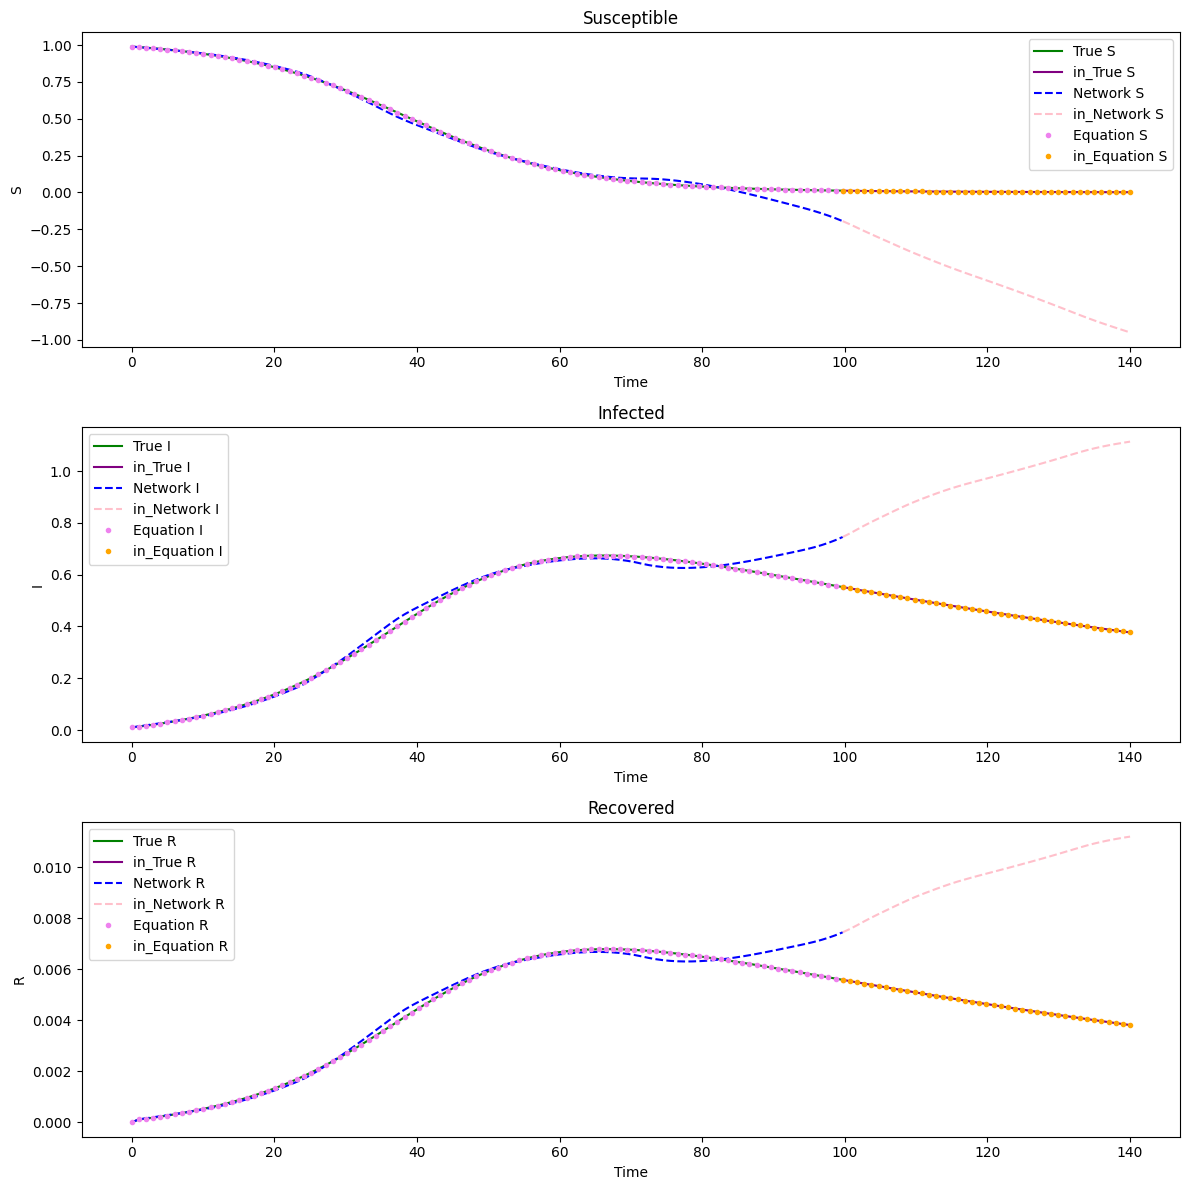

In [54]:
last = int(last)
timeend = int(timeend)
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 0], '-', label='True S', color = 'green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 0], '-', label='in_True S', color = 'purple')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 0], '--', label='Network S', color = 'blue')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 0], '--', label='in_Network S', color = 'pink')
plt.plot(in_t.numpy()[:last], in_NH_true_y.numpy()[:last, 0], '.', label='Equation S', color = 'violet')
plt.plot(in_t.numpy()[last-1:timeend], in_NH_true_y.detach().numpy()[last-1:timeend, 0], '.', label='in_Equation S', color = 'orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 1], '-', label='True I', color = 'green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 1], '-', label='in_True I', color = 'purple')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 1], '--', label='Network I', color = 'blue')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 1], '--', label='in_Network I', color = 'pink')
plt.plot(in_t.numpy()[:last], in_NH_true_y.numpy()[:last, 1], '.', label='Equation I', color = 'violet')
plt.plot(in_t.numpy()[last-1:timeend], in_NH_true_y.detach().numpy()[last-1:timeend, 1], '.', label='in_Equation I', color = 'orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 2], '-', label='True R', color = 'green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 2], '-', label='in_True R', color = 'purple')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 2], '--', label='Network R', color = 'blue')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 2], '--', label='in_Network R', color = 'pink')
plt.plot(in_t.numpy()[:last], in_NH_true_y.numpy()[:last, 2], '.', label='Equation R', color = 'violet')
plt.plot(in_t.numpy()[last-1:timeend], in_NH_true_y.detach().numpy()[last-1:timeend, 2], '.', label='in_Equation R', color = 'orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')

plt.tight_layout()
plt.savefig('picture/in_H-t_SIRmlp.png')
plt.show()

In [262]:
end_time = time.time()
print(f"代码运行时间：{end_time - start_time}秒")

代码运行时间：347.4267225265503秒
